In [20]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.manifold import TSNE

In [21]:
# using sqlite load the data

con = sqlite3.connect('amazon-fine-food-reviews/database.sqlite')
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con)

def partition(x):
    if x<3:
        return 'negative'
    return 'positive'

actual_score = filtered_data['Score']
positive_Negative_reviews = actual_score.map(partition)
filtered_data['Score'] = positive_Negative_reviews

In [22]:
filtered_data.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [23]:
# this query will return all values belongs to one user
# if we look at the results returned we can observe there are reviews which are give at the same time for different products
# we need to clean suc type of records

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

In [24]:
# sort all the data with product Id
# axis = 0 means rows
# inplace = False means performs the operation and returns copy of object. If it is True it will not reurn copy of object
# na_position will first put the Nan's last and then first if given last
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [25]:
# Drop Duplicates
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [26]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [27]:
final.shape

final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

# Text Pre-Porcessing
## Removing Stop Words, Punctuations, Htmnl tags

In [31]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleanText = re.sub(cleanr, ' ', sentence)
    return cleanText

def cleanPunctuations(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

print(stop)

{'hadn', 'will', 'any', 've', 'them', 'hers', 'ours', "you're", 'itself', 'being', 'of', 'is', 'in', 'haven', 'are', 'do', 's', 't', 'have', 'she', 'from', "hadn't", "isn't", 'isn', 'shan', 'very', 'ma', 'yours', 'doing', "wasn't", 'me', "shouldn't", 'my', "mustn't", 'the', 'theirs', 'y', 'what', 'whom', 'into', 'am', "she's", 'shouldn', 'myself', "you'd", 'below', 'an', 'again', 'only', 'her', "weren't", 'wouldn', 'where', 'who', 'those', "mightn't", 'above', 'until', 'other', "couldn't", 'herself', "shan't", 'under', 'further', 'him', 'down', 'why', 'these', 'but', "hasn't", "you'll", 'when', 'after', 'they', 'as', "haven't", 'hasn', 'which', 'we', 'over', 'to', 'wasn', 'a', 'aren', 'out', 'on', 'does', 'himself', 'll', 'had', 'there', 'off', 'now', 'its', 'before', 'you', 'were', 'nor', 'each', 'o', 'doesn', 'i', 'not', 'by', 'for', 'so', 'mightn', 'because', 'same', 'own', "aren't", 'some', "you've", 'd', 'your', 'few', 'needn', "should've", 'that', 'once', 'their', 'it', 'with', '

In [38]:
i =0
all_positive_reviews = []
all_negative_reviews = []
final_string = []
str1 = " " # varaible to store all stemmed words as one string
s= '' # variable to store all stemmed words for every index values

for sent in final['Text'].values:
    filtered_sentence = [] # stores all stemmed words
    sent = cleanHtml(sent)
    for w in sent.split():
        for clean_words in cleanPunctuations(w).split():
            if ((clean_words.isalpha()) & (len(clean_words)>2)):
                if(clean_words.lower() not in stop):
                    s= sno.stem(clean_words.lower()).encode('utf-8')
                    filtered_sentence.append(s)
                    if(final['Score'].values)[i] == 'positive':
                        all_positive_reviews.append(s)
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_reviews.append(s)
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence)
    final_string.append(str1)
    i+=1

In [39]:
final['CleanedText'] = final_string

In [40]:
final.head()

Id   ProductId          UserId                  ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL              shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                        Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4        sally sue "sally sue"   
138690  150508  0006641040     AZGXZ2UUK6X  Catherine Hallberg "(Kate)"   
138691  150509  0006641040  A3CMRKGE0P909G                       Teresa   

        HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
138706                     0                       0  positive   939340800   
138688                     1                       1  positive  1194739200   
138689                     1                       1  positive  1191456000   
138690                     1                       1  positive  1076025600   
138691                     3                       4  positive  1018396800   

                                           Summary  \
138706                   EVERY book is educational   
138688  Love the book, miss the hard cover version   
138689               chicken soup with rice months   
138690      a good swingy rhythm for reading aloud   
138691             A great way to learn the months   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138688  I grew up reading these Sendak books, and watc...   
138689  This is a fun way for children to learn their ...   
138690  This is a great little book to read aloud- it ...   
138691  This is a book of poetry about the months of t...   

                                              CleanedText  
138706  b'witti littl book make son laugh loud recit c...  
138688  b'grew read sendak book watch realli rosi movi...  
138689  b'fun way children learn month year learn poem...  
138690  b'great littl book read nice rhythm well good ...  
138691  b'book poetri month year goe month cute littl ...

In [45]:
pos_reviews = final[final['Score'] == 'positive'].sample(1000)
neg_reviews = final[final['Score'] == 'negative'].sample(1000)

pos_reviews.shape

(1000, 11)

In [47]:
final_1000 = pd.concat([pos_reviews, neg_reviews])

In [48]:
final_1000.shape

(2000, 11)

In [49]:
final_1000.head()

Id   ProductId          UserId  \
441778  477700  B0012C85M0  A1BZJPXGZISBTA   
410765  444243  B001M09BS4  A2Q7EVEKQ62YNC   
502841  543693  B006MONQMC  A2W0XCWOK3MW6F   
478310  517239  B002YLCO7K   AIUV1L8QSRS18   
251632  272817  B000VTRI3C  A1B7KOKYA2YGWR   

                                    ProfileName  HelpfulnessNumerator  \
441778                    VA Reader "VA Reader"                     0   
410765                                   JayDee                     4   
502841  Karen Woodworth Roman "Happy Librarian"                     0   
478310                              Anita Burns                     0   
251632                                daniellec                     1   

        HelpfulnessDenominator     Score        Time  \
441778                       1  positive  1238716800   
410765                       5  positive  1289779200   
502841                       0  positive  1332374400   
478310                       0  positive  1317686400   
251632                       1  positive  1283212800   

                                                  Summary  \
441778                               great lunch box item   
410765  Please bring it back!  Call or Write to Quaker...   
502841                     Like it for a change of taste.   
478310                             Great Grains - AMAZING   
251632                          Wellness CORE Reduced Fat   

                                                     Text  \
441778  This is an affordable alternative to the more ...   
410765  Like several others, I was devastated when I n...   
502841  I don't drink as much water as I should, so I ...   
478310  I haven't used this for bread yet. Too busy ri...   
251632  I got this dog food at a great price and fast ...   

                                              CleanedText  
441778  b'afford altern expens singl serv soy milk tas...  
410765  b'like sever other devast longer could find or...  
502841  b'dont drink much water happi get bottl review...  
478310  b'havent use bread yet busi right husband made...  
251632  b'got dog food great price fast free ship mini...

In [54]:
# Bag Of Words
count_vect = CountVectorizer() #in scikit-learn
final_count = count_vect.fit_transform(final_1000['CleanedText'].values)

In [57]:
type(final_count)

scipy.sparse.csr.csr_matrix

In [71]:
 from sklearn.preprocessing import StandardScaler

standardized_data = StandardScaler(with_mean = False).fit_transform(final_count)
standardized_data.shape

C:\Users\Avinash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(2000, 6616)

In [72]:
# convert sparse to dense as tsne takes dense vector
# Densse Data is required for t-sne instead of sparse matrix
standardized_data = standardized_data.todense()
label_1000 = final_1000['Score']
model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(standardized_data)

tsne_data = np.vstack((tsne_data.T, label_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

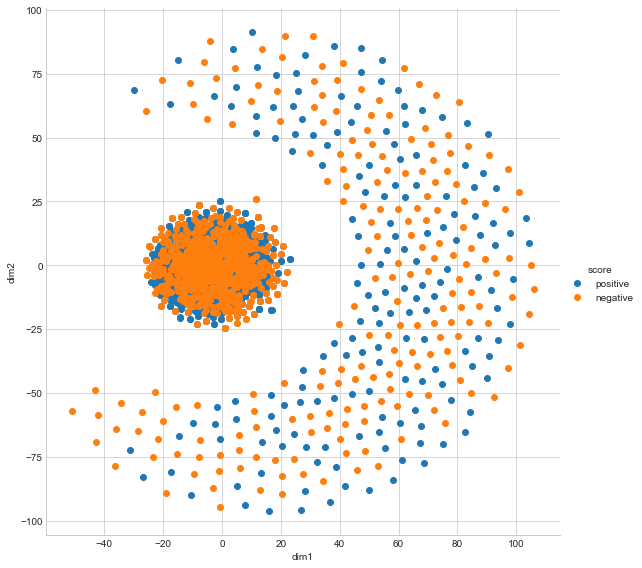

In [73]:
sns.set_style("whitegrid")
sns.FacetGrid(tsne_df, hue="score", size=8) \
    .map(plt.scatter, "dim1", "dim2") \
    .add_legend()
    
plt.show()

In [75]:
# Plot By converting to Bi-Grams

count_vect = CountVectorizer(ngram_range=(1,2)) #in scikit-learn
final_count = count_vect.fit_transform(final_1000['CleanedText'].values)

final_count.shape                    

(2000, 68538)

In [76]:
 from sklearn.preprocessing import StandardScaler

standardized_data = StandardScaler(with_mean = False).fit_transform(final_count)
standardized_data.shape

C:\Users\Avinash\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(2000, 68538)

In [77]:
# convert sparse to dense as tsne takes dense vector
# Densse Data is required for t-sne instead of sparse matrix
standardized_data = standardized_data.todense()
label_1000 = final_1000['Score']
model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(standardized_data)

tsne_data = np.vstack((tsne_data.T, label_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

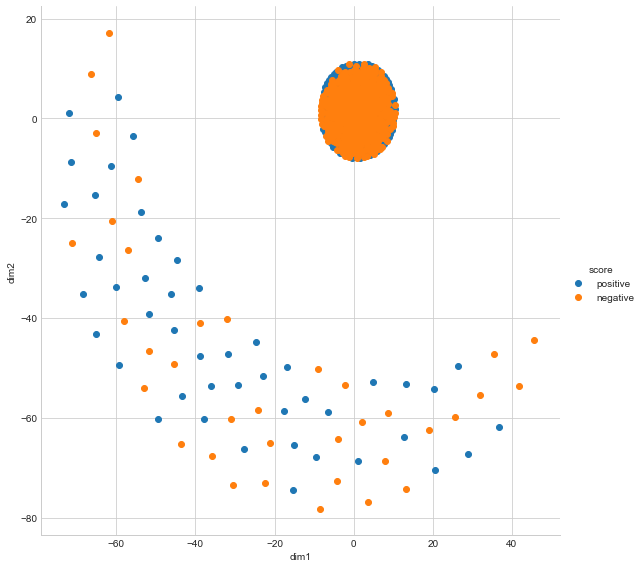

In [78]:
sns.set_style("whitegrid")
sns.FacetGrid(tsne_df, hue="score", size=8) \
    .map(plt.scatter, "dim1", "dim2") \
    .add_legend()
    
plt.show()

In [82]:
# Tf-IDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_1000['CleanedText'].values)

In [83]:
 from sklearn.preprocessing import StandardScaler

standardized_data = StandardScaler(with_mean = False).fit_transform(final_tf_idf)
standardized_data.shape

(2000, 68538)

In [84]:
# convert sparse to dense as tsne takes dense vector
# Densse Data is required for t-sne instead of sparse matrix
standardized_data = standardized_data.todense()
label_1000 = final_1000['Score']
model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(standardized_data)

tsne_data = np.vstack((tsne_data.T, label_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

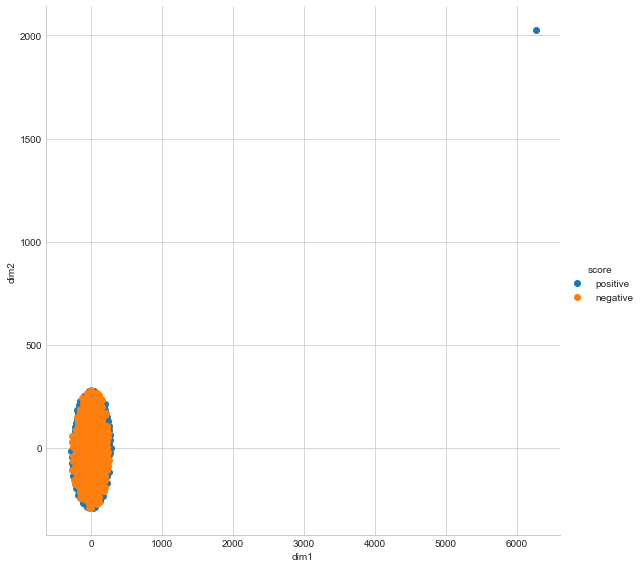

In [86]:
sns.set_style("whitegrid")
sns.FacetGrid(tsne_df, hue="score", size=8) \
    .map(plt.scatter, "dim1", "dim2") \
    .add_legend()
    
plt.show()

In [90]:
# W2V
# The output of this will be like [[list], [list], ....[list]]
i=0
list_of_sen = []
for sen in final_1000['Text'].values:
    filtered_sentence = []
    sen = cleanHtml(sen)
    for w in sen.split():
        for cleaned_word in cleanPunctuations(w).split():
            if(cleaned_word.isalpha()):
                filtered_sentence.append(cleaned_word.lower())
            else:
                continue
    list_of_sen.append(filtered_sentence)

In [91]:
import gensim
# min_count = 5 tell construct a w2v if it occurs min 5 times otherwise don't construct
#  size=50 dimensions
# workers = 4 if we have 4 cores it uses all cores
w2v_model = gensim.models.Word2Vec(list_of_sen, min_count=5, size=50, workers=4)

In [93]:
words = list(w2v_model.wv.vocab)
print(len(words))

2656


In [110]:
# Average w2v

sent_vector = []
for sent in list_of_sen:
    sent_vec = np.zeros(50) # since we gave 50 dimension in w2v we take 50 zeros
    count= 0
    for word in sent:
        try:
            vec= w2v_model.wv[word]
            sent_vec+= vec
            count+= 1
        except:
            pass
    sent_vec/= count
    sent_vector.append(sent_vec)
print(len(sent_vector))

2000


In [111]:
 from sklearn.preprocessing import StandardScaler

standardized_data = StandardScaler(with_mean = False).fit_transform(sent_vector)
standardized_data.shape

(2000, 50)

In [112]:
label_1000 = final_1000['Score']
model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(standardized_data)

tsne_data = np.vstack((tsne_data.T, label_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

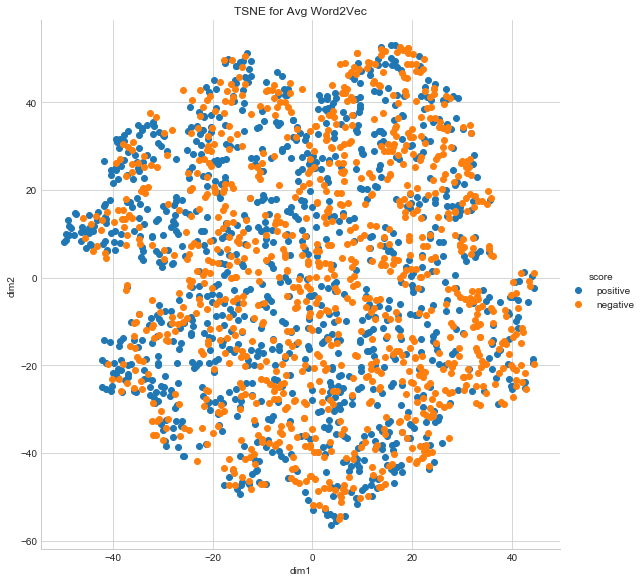

In [113]:
sns.set_style("whitegrid")
sns.FacetGrid(tsne_df, hue="score", size=8) \
    .map(plt.scatter, "dim1", "dim2") \
    .add_legend()
plt.title("TSNE for Avg Word2Vec")
plt.show()

In [103]:
tfidf_sent_vectors = []

for sent in list_of_sen:
    sen_vec = np.zeros(0)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sen_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sen_vec/= weight_sum
    tfidf_sent_vectors.append(sent_vec)

In [104]:
 from sklearn.preprocessing import StandardScaler

standardized_data = StandardScaler(with_mean = False).fit_transform(tfidf_sent_vectors)
standardized_data.shape

(2000, 50)

In [105]:
label_1000 = final_1000['Score']
model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(standardized_data)

tsne_data = np.vstack((tsne_data.T, label_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

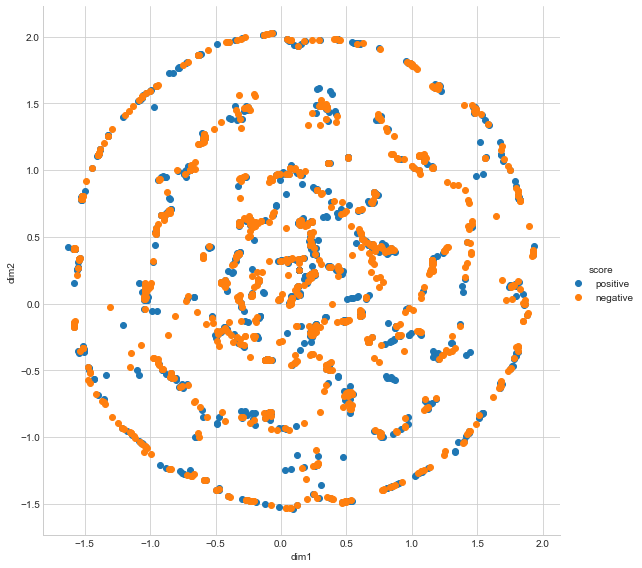

In [106]:
sns.set_style("whitegrid")
sns.FacetGrid(tsne_df, hue="score", size=8) \
    .map(plt.scatter, "dim1", "dim2") \
    .add_legend()
    
plt.title("TSNE for TF-IDF Word2vec")
plt.show()